# CS 541 Final Project

## 1. Loading Dataset

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#dataset source - https://www.kaggle.com/datasets/dansbecker/nba-shot-logs
df = pd.read_csv("shot_logs.csv")

In [4]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## 2. Data Cleaning

#### Fixing and dropping features


##### Matchup gives an idea about the date and teams. These are not relevant for a player, so dropping this.

In [5]:
df.MATCHUP

0         MAR 04, 2015 - CHA @ BKN
1         MAR 04, 2015 - CHA @ BKN
2         MAR 04, 2015 - CHA @ BKN
3         MAR 04, 2015 - CHA @ BKN
4         MAR 04, 2015 - CHA @ BKN
                    ...           
128064    OCT 29, 2014 - BKN @ BOS
128065    OCT 29, 2014 - BKN @ BOS
128066    OCT 29, 2014 - BKN @ BOS
128067    OCT 29, 2014 - BKN @ BOS
128068    OCT 29, 2014 - BKN @ BOS
Name: MATCHUP, Length: 128069, dtype: object

In [6]:
df = df.drop(['MATCHUP'], axis = 1)

##### Location, whether the team is home team or an away team, irrelevant so dropping this.

In [7]:
df.LOCATION

0         A
1         A
2         A
3         A
4         A
         ..
128064    A
128065    A
128066    A
128067    A
128068    A
Name: LOCATION, Length: 128069, dtype: object

In [8]:
df = df.drop(['LOCATION'], axis = 1)

##### Gives the same information as the FGM, drop this feature

In [9]:
df = df.drop(['W'], axis = 1)

In [10]:
df = df.drop(['SHOT_NUMBER'], axis = 1)

###### Formatting of time is inappropriate for using, convert this to amount of seconds left in a period

In [11]:
df.GAME_CLOCK

0          1:09
1          0:14
2          0:00
3         11:47
4         10:34
          ...  
128064     1:52
128065    11:28
128066    11:10
128067     2:37
128068     0:12
Name: GAME_CLOCK, Length: 128069, dtype: object

In [12]:
df['SECONDS_LEFT_IN_PERIOD'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['LAST_SHOT'] = 0
df.loc[df['SECONDS_LEFT_IN_PERIOD'] <= 1, 'LAST_SHOT'] = 1

In [13]:
df = df.drop(['GAME_CLOCK'], axis = 1)

##### Fix negative touch time

In [14]:
df = df[df['TOUCH_TIME'] >= 0]

##### Shot result gives same information as the FGM, so drop this feature

In [15]:
df = df.drop(['SHOT_RESULT'], axis = 1)

##### Dropping type of points


In [16]:
df = df.drop(['PTS'], axis = 1)

Dropping null values

In [17]:
df.isna().any()

GAME_ID                       False
FINAL_MARGIN                  False
PERIOD                        False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
player_name                   False
player_id                     False
SECONDS_LEFT_IN_PERIOD        False
LAST_SHOT                     False
dtype: bool

In [18]:
df["SHOT_CLOCK"].fillna(df["SHOT_CLOCK"].mean(), inplace=True)

####Creating shot marker 

In [19]:
df['SHOT_MARKER'] = df['FGM'].replace(['0', '1'], ['0', '^'], inplace=False)

#### Get absolute value of margin

In [20]:
df['ABS_FINAL_MARGIN'] = abs(df['FINAL_MARGIN'])

### Exploring data for extracting more relevant information

Just knowing the closest defender is not a useful feature, so improving on available features. Finding the blocking efficiency of the defender. Also, using the information of efficiency with count of blocked shots, and attempted shots, a ranking for the defenders is obtained. 

In [21]:
defenders = df[['CLOSEST_DEFENDER_PLAYER_ID', 'CLOSEST_DEFENDER']]

In [22]:
df['CLOSEST_DEFENDER_EFFICIENCY'] = [0.0] * len(df)

for defender_id in df['CLOSEST_DEFENDER_PLAYER_ID']:
    temp_df = df[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id]
    temp_eff = (temp_df['FGM'] == 0).sum() / temp_df['FGM'].count()
    df.loc[df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id, 'CLOSEST_DEFENDER_EFFICIENCY'] = temp_eff
    
    blockedShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id) & (df['FGM'] == 0)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    allShots = df[(df['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id)]['CLOSEST_DEFENDER_PLAYER_ID'].count()
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
    defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKING_EFFICIENCY'] = blockedShots/allShots


C:\Users\madha\AppData\Local\Temp\ipykernel_13780\2737887701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'BLOCKED_SHOTS'] = blockedShots
C:\Users\madha\AppData\Local\Temp\ipykernel_13780\2737887701.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders.loc[(defenders['CLOSEST_DEFENDER_PLAYER_ID'] == defender_id), 'ALL_SHOTS'] = allShots
C:\Users\madha\AppData\Local\Temp\ipykernel_13780\2737887701.py:12: SettingWithCopyW

In [23]:
defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

C:\Users\madha\AppData\Local\Temp\ipykernel_13780\3135344425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders['CLOSEST_DEFENDER_RANK'] = defenders[['ALL_SHOTS','BLOCKED_SHOTS', 'BLOCKING_EFFICIENCY']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)


In [24]:
defenders

,CLOSEST_DEFENDER_PLAYER_ID,CLOSEST_DEFENDER,BLOCKED_SHOTS,ALL_SHOTS,BLOCKING_EFFICIENCY,CLOSEST_DEFENDER_RANK
0,101187,"Anderson, Alan",209.0,382.0,0.547120,135
1,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
2,202711,"Bogdanovic, Bojan",189.0,319.0,0.592476,173
3,203900,"Brown, Markel",27.0,50.0,0.540000,388
4,201152,"Young, Thaddeus",275.0,531.0,0.517891,56
...,...,...,...,...,...,...
128064,203935,"Smart, Marcus",163.0,294.0,0.554422,203
128065,202323,"Turner, Evan",292.0,497.0,0.587525,77
128066,201977,"Thornton, Marcus",71.0,127.0,0.559055,327
128067,202340,"Bradley, Avery",247.0,448.0,0.551339,105


#### Plot the features to understand how they affect the result of a shot

<Axes: xlabel='PERIOD', ylabel='Count'>

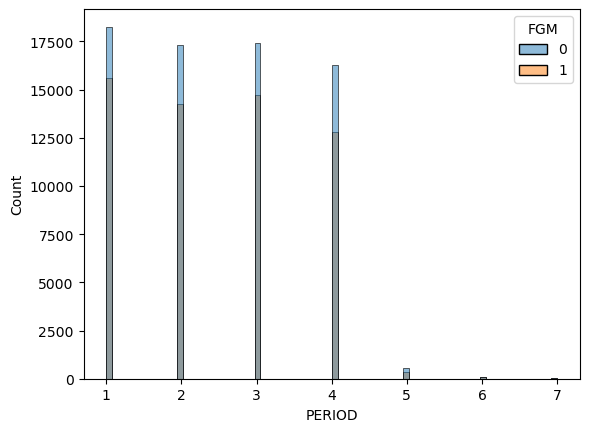

In [25]:
sns.histplot(df, x="PERIOD", hue="FGM", element="bars")

<Axes: xlabel='SHOT_CLOCK', ylabel='Count'>

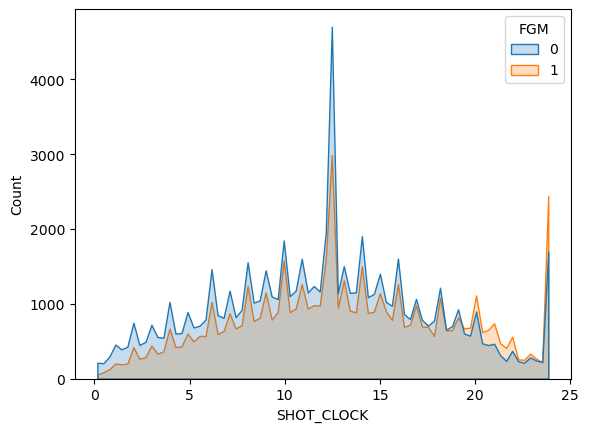

In [26]:
sns.histplot(df, x="SHOT_CLOCK", hue="FGM", element="poly")

<Axes: xlabel='DRIBBLES', ylabel='count'>

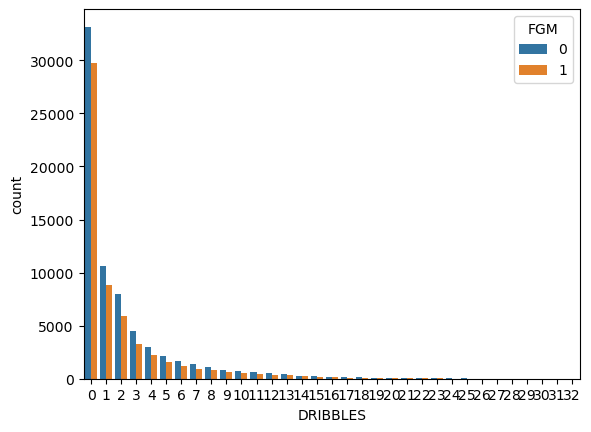

In [27]:
sns.countplot(data=df, x='DRIBBLES', hue='FGM')

<Axes: xlabel='TOUCH_TIME', ylabel='Count'>

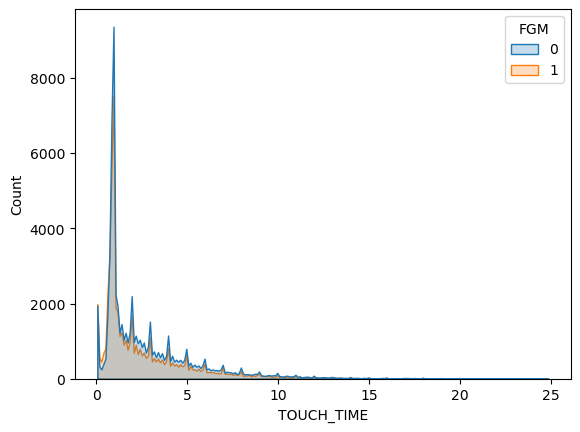

In [28]:
sns.histplot(df, x="TOUCH_TIME", hue="FGM", element="poly")

<Axes: xlabel='SHOT_DIST', ylabel='Count'>

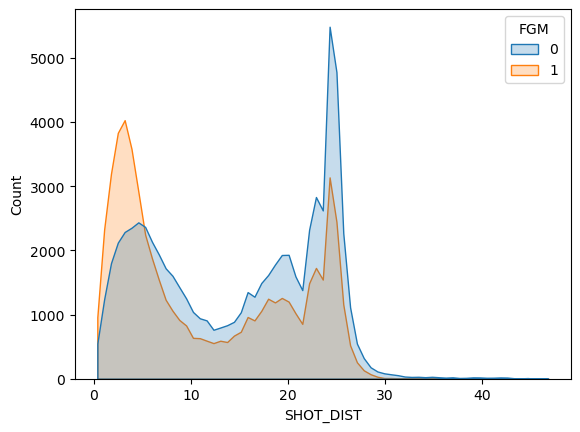

In [29]:
sns.histplot(df, x="SHOT_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSE_DEF_DIST', ylabel='Count'>

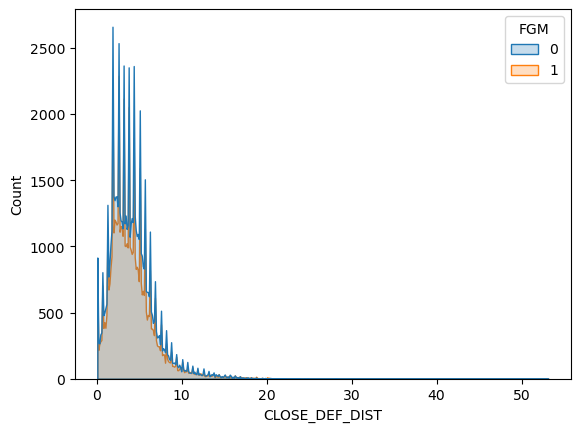

In [30]:
sns.histplot(df, x="CLOSE_DEF_DIST", hue="FGM", element="poly")

<Axes: xlabel='CLOSEST_DEFENDER_EFFICIENCY', ylabel='Count'>

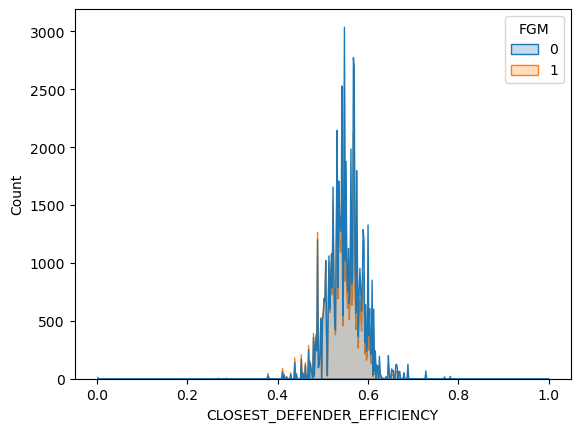

In [31]:
sns.histplot(df, x="CLOSEST_DEFENDER_EFFICIENCY", hue="FGM", element="poly")

<Axes: xlabel='SECONDS_LEFT_IN_PERIOD', ylabel='Count'>

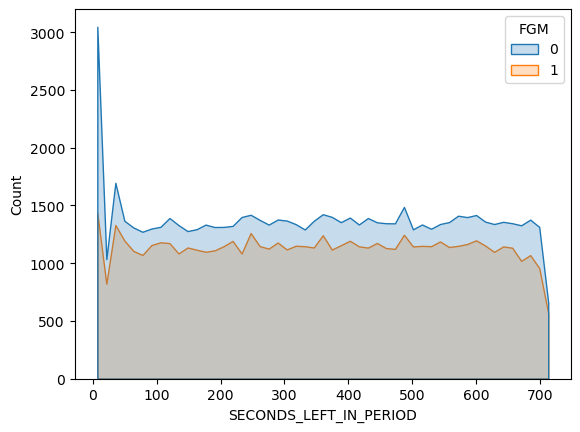

In [32]:
sns.histplot(df, x="SECONDS_LEFT_IN_PERIOD", hue="FGM", element="poly")

#### Find correlation between features

In [33]:
selected_features = df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY','SECONDS_LEFT_IN_PERIOD','FGM']].copy()

<Axes: >

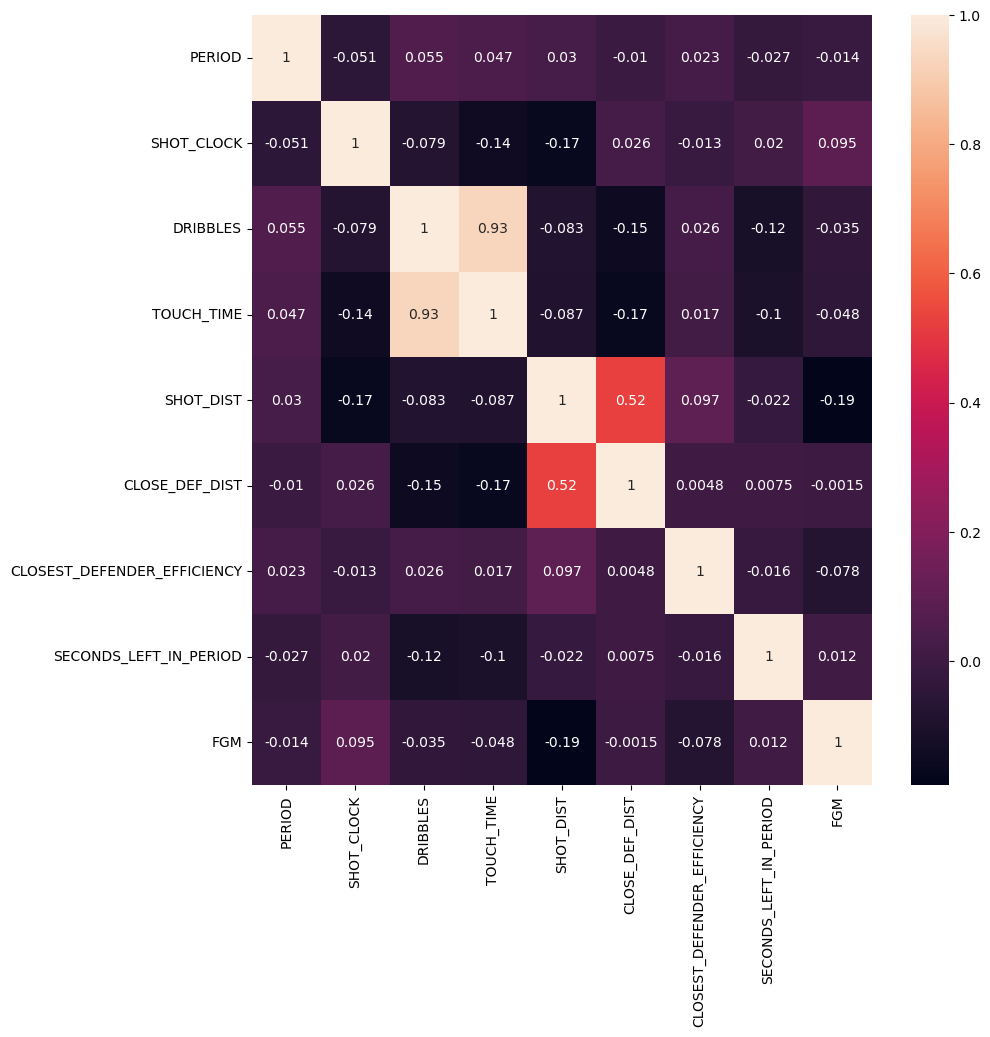

In [34]:
corr = selected_features.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True)

### Clustering Shots by Context

C:\Users\madha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


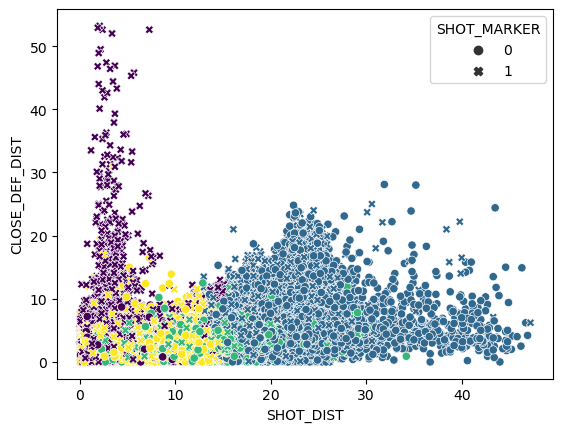

In [35]:
# Clustering

kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']])
# not using SECONDS_LEFT_IN_PERIOD, using LAST_SHOT instead

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [36]:
df['CLUSTER'] = kmeans.labels_
for label in range(0, 4):
    print(label, float(sum(df[df['CLUSTER'] == label]['FGM'])) / float(len(df[df['CLUSTER'] == label]['FGM'])))


0 0.6005732459067886
1 0.3738167344466557
2 0.4118044604640685
3 0.4842947368421053


In [37]:
# Create Cluster average columns

for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
      df['CLUSTER_'+col+'_AVG'] = [0.0] * len(df)
df['CLUSTER_SHOOTING_EFFICIENCY'] = [0.0] * len(df)

for cluster_id in list(df['CLUSTER'].unique()):
    df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_SHOOTING_EFFICIENCY']  = float(sum(df[df['CLUSTER'] == cluster_id]['FGM'])) / float(len(df[df['CLUSTER'] == cluster_id]['FGM']))
    for col in ['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST','CLOSE_DEF_DIST', 'CLOSEST_DEFENDER_EFFICIENCY', 'LAST_SHOT']:
        temp_avg = df[df['CLUSTER'] == cluster_id][col].mean()
        df.loc[df['CLUSTER'] == cluster_id, 'CLUSTER_'+col+'_AVG'] = temp_avg


In [38]:
df.columns

Index(['GAME_ID', 'FINAL_MARGIN', 'PERIOD', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'player_name',
       'player_id', 'SECONDS_LEFT_IN_PERIOD', 'LAST_SHOT', 'SHOT_MARKER',
       'ABS_FINAL_MARGIN', 'CLOSEST_DEFENDER_EFFICIENCY', 'CLUSTER',
       'CLUSTER_PERIOD_AVG', 'CLUSTER_SHOT_CLOCK_AVG', 'CLUSTER_DRIBBLES_AVG',
       'CLUSTER_TOUCH_TIME_AVG', 'CLUSTER_SHOT_DIST_AVG',
       'CLUSTER_CLOSE_DEF_DIST_AVG', 'CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG',
       'CLUSTER_LAST_SHOT_AVG', 'CLUSTER_SHOOTING_EFFICIENCY'],
      dtype='object')

#### Aggregating features for each player

In [46]:
agg_functions = {'player_id' : 'first','PERIOD': 'mean', 'SHOT_CLOCK': 'mean', 'DRIBBLES': 'mean','TOUCH_TIME': 'mean', 'SHOT_DIST': 'mean', 'CLOSE_DEF_DIST': 'mean','CLOSEST_DEFENDER_EFFICIENCY': 'mean', 'LAST_SHOT': 'mean'}
players = df.groupby(df['player_name']).aggregate(agg_functions)


players_data = df[['player_name', 'player_id']]
players_data = players_data.drop_duplicates()
players_data = players_data.reset_index()

#Shot distance
shotDist = df.groupby('player_name')['SHOT_DIST'].mean()
shotDist = shotDist.reset_index()
shotDist.columns = ['player_name', 'shot_distance']
players_data['shot_distance'] = shotDist['shot_distance']

#Seconds left in period
secLeft = df.groupby('player_name')['SECONDS_LEFT_IN_PERIOD'].mean()
secLeft = secLeft.reset_index()
secLeft.columns = ['player_name', 'SECONDS_LEFT_IN_PERIOD']
players_data['SECONDS_LEFT_IN_PERIOD'] = secLeft['SECONDS_LEFT_IN_PERIOD']

#Closest defender efficiency
defEff = df.groupby('player_name')['CLOSEST_DEFENDER_EFFICIENCY'].mean()
defEff = defEff.reset_index()
defEff.columns = ['player_name', 'CLOSEST_DEFENDER_EFFICIENCY']
players_data['CLOSEST_DEFENDER_EFFICIENCY'] = defEff['CLOSEST_DEFENDER_EFFICIENCY']

#Shot clock
shotClk = df.groupby('player_name')['SHOT_CLOCK'].mean()
shotClk = shotClk.reset_index()
shotClk.columns = ['player_name', 'SHOT_CLOCK']
players_data['SHOT_CLOCK'] = shotClk['SHOT_CLOCK']

#Closest defender distance
defDist = df.groupby('player_name')['CLOSE_DEF_DIST'].mean()
defDist = defDist.reset_index()
defDist.columns = ['player_name', 'CLOSE_DEF_DIST']
players_data['CLOSE_DEF_DIST'] = defDist['CLOSE_DEF_DIST'] 

#Touch time
tt = df.groupby('player_name')['TOUCH_TIME'].mean()
tt = tt.reset_index()
tt.columns = ['player_name', 'TOUCH_TIME']
players_data['TOUCH_TIME'] = tt['TOUCH_TIME'] 

#Period
prd = df.groupby('player_name')['PERIOD'].mean()
prd = prd.reset_index()
prd.columns = ['player_name', 'PERIOD']
players_data['PERIOD'] = prd['PERIOD'] 

#Dribbles
drb = df.groupby('player_name')['DRIBBLES'].mean()
drb = drb.reset_index()
drb.columns = ['player_name', 'DRIBBLES']
players_data['DRIBBLES'] = drb['DRIBBLES'] 

#Attempted Shots
periodAvg = df.groupby('player_name')['CLUSTER_PERIOD_AVG'].mean()
periodAvg = periodAvg.reset_index()
periodAvg.columns = ['player_name', 'CLUSTER_PERIOD_AVG']
players_data['CLUSTER_PERIOD_AVG'] = periodAvg['CLUSTER_PERIOD_AVG'] 

#Attempted Shots
shotClkAvg = df.groupby('player_name')['CLUSTER_SHOT_CLOCK_AVG'].mean()
shotClkAvg = shotClkAvg.reset_index()
shotClkAvg.columns = ['player_name', 'CLUSTER_SHOT_CLOCK_AVG']
players_data['CLUSTER_SHOT_CLOCK_AVG'] = shotClkAvg['CLUSTER_SHOT_CLOCK_AVG'] 

#Attempted Shots
dribblesAvg = df.groupby('player_name')['CLUSTER_DRIBBLES_AVG'].mean()
dribblesAvg = dribblesAvg.reset_index()
dribblesAvg.columns = ['player_name', 'CLUSTER_DRIBBLES_AVG']
players_data['CLUSTER_DRIBBLES_AVG'] = dribblesAvg['CLUSTER_DRIBBLES_AVG'] 

#Attempted Shots
ttAvg = df.groupby('player_name')['CLUSTER_TOUCH_TIME_AVG'].mean()
ttAvg = ttAvg.reset_index()
ttAvg.columns = ['player_name', 'CLUSTER_TOUCH_TIME_AVG']
players_data['CLUSTER_TOUCH_TIME_AVG'] = ttAvg['CLUSTER_TOUCH_TIME_AVG'] 

#Attempted Shots
stAvg = df.groupby('player_name')['CLUSTER_SHOT_DIST_AVG'].mean()
stAvg = stAvg.reset_index()
stAvg.columns = ['player_name', 'CLUSTER_SHOT_DIST_AVG']
players_data['CLUSTER_SHOT_DIST_AVG'] = stAvg['CLUSTER_SHOT_DIST_AVG'] 

#Attempted Shots
defDistAvg = df.groupby('player_name')['CLUSTER_CLOSE_DEF_DIST_AVG'].mean()
defDistAvg = defDistAvg.reset_index()
defDistAvg.columns = ['player_name', 'CLUSTER_CLOSE_DEF_DIST_AVG']
players_data['CLUSTER_CLOSE_DEF_DIST_AVG'] = defDistAvg['CLUSTER_CLOSE_DEF_DIST_AVG'] 

#Attempted Shots
defEffAvg = df.groupby('player_name')['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'].mean()
defEffAvg = defEffAvg.reset_index()
defEffAvg.columns = ['player_name', 'CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG']
players_data['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'] = defEffAvg['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'] 

#Attempted Shots
lsAvg = df.groupby('player_name')['CLUSTER_LAST_SHOT_AVG'].mean()
lsAvg = lsAvg.reset_index()
lsAvg.columns = ['player_name', 'CLUSTER_LAST_SHOT_AVG']
players_data['CLUSTER_LAST_SHOT_AVG'] = lsAvg['CLUSTER_LAST_SHOT_AVG'] 

#Attempted Shots
seAvg = df.groupby('player_name')['CLUSTER_SHOOTING_EFFICIENCY'].mean()
seAvg = seAvg.reset_index()
seAvg.columns = ['player_name', 'CLUSTER_SHOOTING_EFFICIENCY']
players_data['CLUSTER_SHOOTING_EFFICIENCY'] = seAvg['CLUSTER_SHOOTING_EFFICIENCY'] 

#Attempted Shots
lstSht = df.groupby('player_name')['LAST_SHOT'].mean()
lstSht = lstSht.reset_index()
lstSht.columns = ['player_name', 'LAST_SHOT']
players_data['LAST_SHOT'] = lstSht['LAST_SHOT'] 

players

In [47]:
players['player_id']

player_name
aaron brooks       201166
aaron gordon       203932
al farouq aminu    202329
al horford         201143
al jefferson         2744
                    ...  
wesley matthews    202083
wilson chandler    201163
zach lavine        203897
zach randolph        2216
zaza pachulia        2585
Name: player_id, Length: 281, dtype: int64

In [49]:
for player_id in players['player_id']:
    df_temp = df[df['player_id'] == player_id]
    players.loc[(players['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    players.loc[(players['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    players.loc[(players['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()
    
    df.loc[(df['player_id'] == player_id), 'ATTEMPTED_SHOTS'] = df_temp['FGM'].count()
    df.loc[(df['player_id'] == player_id), 'BASKETS'] = (df_temp['FGM'] == 1).sum()
    df.loc[(df['player_id'] == player_id), 'SHOOTING_EFFICIENCY'] = ((df_temp['FGM'] == 1).sum())/df_temp['FGM'].count()

In [52]:
# players[players['player_id'] == 203148]
players

,player_id,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,CLOSEST_DEFENDER_EFFICIENCY,LAST_SHOT,ATTEMPTED_SHOTS,BASKETS,SHOOTING_EFFICIENCY
player_name,,,,,,,,,,,,
aaron brooks,201166,2.826476,11.879179,5.422182,4.977996,15.055635,3.662791,0.551191,0.026834,559.0,232.0,0.415027
aaron gordon,203932,2.288462,12.943281,1.355769,2.068269,10.062500,4.152885,0.540020,0.009615,104.0,55.0,0.528846
al farouq aminu,202329,2.465116,13.323462,0.515504,1.401163,12.893411,4.972093,0.543273,0.011628,258.0,111.0,0.430233
al horford,201143,2.527349,11.766145,0.538569,1.814867,11.989201,4.889201,0.541412,0.005610,713.0,386.0,0.541374
al jefferson,2744,2.440252,10.596858,0.700629,2.658239,9.340881,3.036855,0.542361,0.001258,795.0,380.0,0.477987
...,...,...,...,...,...,...,...,...,...,...,...,...
wesley matthews,202083,2.594920,12.514318,1.179144,2.124465,18.522193,4.870187,0.553939,0.006684,748.0,336.0,0.449198
wilson chandler,201163,2.330150,12.925592,1.499318,2.363847,15.371214,4.066166,0.550207,0.004093,733.0,304.0,0.414734
zach lavine,203897,2.649596,12.771985,3.967655,4.217251,14.776011,4.146631,0.555221,0.024259,371.0,157.0,0.423181


In [53]:
df

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,...,CLUSTER_DRIBBLES_AVG,CLUSTER_TOUCH_TIME_AVG,CLUSTER_SHOT_DIST_AVG,CLUSTER_CLOSE_DEF_DIST_AVG,CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG,CLUSTER_LAST_SHOT_AVG,CLUSTER_SHOOTING_EFFICIENCY,ATTEMPTED_SHOTS,BASKETS,SHOOTING_EFFICIENCY
0,21400899,24,1,10.800000,2,1.9,7.7,2,"Anderson, Alan",101187,...,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295,372.0,149.0,0.400538
1,21400899,24,1,3.400000,0,0.8,28.2,3,"Bogdanovic, Bojan",202711,...,0.930847,1.836084,22.125424,5.681777,0.550442,0.015385,0.373817,372.0,149.0,0.400538
2,21400899,24,1,12.450301,3,2.7,10.1,2,"Bogdanovic, Bojan",202711,...,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295,372.0,149.0,0.400538
3,21400899,24,2,10.300000,2,1.9,17.2,2,"Brown, Markel",203900,...,0.930847,1.836084,22.125424,5.681777,0.550442,0.015385,0.373817,372.0,149.0,0.400538
4,21400899,24,2,10.900000,2,2.7,3.7,2,"Young, Thaddeus",201152,...,1.685698,2.787601,6.483705,2.604011,0.544522,0.009179,0.484295,372.0,149.0,0.400538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,-16,3,18.300000,5,6.2,8.7,2,"Smart, Marcus",203935,...,1.541600,2.125776,4.193188,2.927881,0.544182,0.000039,0.600573,611.0,273.0,0.446809
128065,21400006,-16,4,19.800000,4,5.2,0.6,2,"Turner, Evan",202323,...,1.541600,2.125776,4.193188,2.927881,0.544182,0.000039,0.600573,611.0,273.0,0.446809
128066,21400006,-16,4,23.000000,2,4.2,16.9,2,"Thornton, Marcus",201977,...,0.930847,1.836084,22.125424,5.681777,0.550442,0.015385,0.373817,611.0,273.0,0.446809
128067,21400006,-16,4,9.100000,4,4.5,18.3,2,"Bradley, Avery",202340,...,0.930847,1.836084,22.125424,5.681777,0.550442,0.015385,0.373817,611.0,273.0,0.446809


In [56]:
# compare cluster average efficiency to the total average efficiency and reward/penalize for makes/misses

avg_efficiency = sum(df['FGM']) / len(df)

players['Adjusted_Efficiency'] = [0.0] * len(players)
for pid in players['player_id']:
    temp_df = df[df['player_id'] == pid]
    adj_attempts = 0
    adj_makes = 0
    for shot in temp_df.iterrows():
        adj_attempts += 1
        if shot[1]['FGM'] == 0:
            if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
                adj_attempts += (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
            else:
                adj_attempts -= (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])
        else:
            adj_makes += 1
            if shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] >= avg_efficiency:
                adj_makes -= (shot[1]['CLUSTER_SHOOTING_EFFICIENCY'] - avg_efficiency)
            else:
                adj_makes += (avg_efficiency - shot[1]['CLUSTER_SHOOTING_EFFICIENCY'])

                
    players.loc[players['player_id'] == pid, 'Adjusted_Efficiency'] = adj_makes/adj_attempts



#if temp['SHOT_CLOCK'].iloc[0] > df['SHOT_CLOCK'].mean():
 # players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
#else:
 # reward = abs((temp['SHOT_CLOCK']-df['SHOT_CLOCK'].mean())/(df['SHOT_CLOCK'].max() - df['SHOT_CLOCK'].mean()))*shotClkImpt.iloc[0]
 # players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward

In [57]:
players

,player_id,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,CLOSEST_DEFENDER_EFFICIENCY,LAST_SHOT,ATTEMPTED_SHOTS,BASKETS,SHOOTING_EFFICIENCY,Adjusted_Efficiency
player_name,,,,,,,,,,,,,
aaron brooks,201166,2.826476,11.879179,5.422182,4.977996,15.055635,3.662791,0.551191,0.026834,559.0,232.0,0.415027,0.425023
aaron gordon,203932,2.288462,12.943281,1.355769,2.068269,10.062500,4.152885,0.540020,0.009615,104.0,55.0,0.528846,0.496670
al farouq aminu,202329,2.465116,13.323462,0.515504,1.401163,12.893411,4.972093,0.543273,0.011628,258.0,111.0,0.430233,0.410146
al horford,201143,2.527349,11.766145,0.538569,1.814867,11.989201,4.889201,0.541412,0.005610,713.0,386.0,0.541374,0.535983
al jefferson,2744,2.440252,10.596858,0.700629,2.658239,9.340881,3.036855,0.542361,0.001258,795.0,380.0,0.477987,0.459009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
wesley matthews,202083,2.594920,12.514318,1.179144,2.124465,18.522193,4.870187,0.553939,0.006684,748.0,336.0,0.449198,0.469534
wilson chandler,201163,2.330150,12.925592,1.499318,2.363847,15.371214,4.066166,0.550207,0.004093,733.0,304.0,0.414734,0.411950
zach lavine,203897,2.649596,12.771985,3.967655,4.217251,14.776011,4.146631,0.555221,0.024259,371.0,157.0,0.423181,0.421372


In [59]:
# get adjustment percentage

players['Adjustment'] = players['Adjusted_Efficiency'] - players['SHOOTING_EFFICIENCY']

In [60]:
players

,player_id,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,CLOSEST_DEFENDER_EFFICIENCY,LAST_SHOT,ATTEMPTED_SHOTS,BASKETS,SHOOTING_EFFICIENCY,Adjusted_Efficiency,Adjustment
player_name,,,,,,,,,,,,,,
aaron brooks,201166,2.826476,11.879179,5.422182,4.977996,15.055635,3.662791,0.551191,0.026834,559.0,232.0,0.415027,0.425023,0.009996
aaron gordon,203932,2.288462,12.943281,1.355769,2.068269,10.062500,4.152885,0.540020,0.009615,104.0,55.0,0.528846,0.496670,-0.032176
al farouq aminu,202329,2.465116,13.323462,0.515504,1.401163,12.893411,4.972093,0.543273,0.011628,258.0,111.0,0.430233,0.410146,-0.020086
al horford,201143,2.527349,11.766145,0.538569,1.814867,11.989201,4.889201,0.541412,0.005610,713.0,386.0,0.541374,0.535983,-0.005392
al jefferson,2744,2.440252,10.596858,0.700629,2.658239,9.340881,3.036855,0.542361,0.001258,795.0,380.0,0.477987,0.459009,-0.018979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wesley matthews,202083,2.594920,12.514318,1.179144,2.124465,18.522193,4.870187,0.553939,0.006684,748.0,336.0,0.449198,0.469534,0.020336
wilson chandler,201163,2.330150,12.925592,1.499318,2.363847,15.371214,4.066166,0.550207,0.004093,733.0,304.0,0.414734,0.411950,-0.002784
zach lavine,203897,2.649596,12.771985,3.967655,4.217251,14.776011,4.146631,0.555221,0.024259,371.0,157.0,0.423181,0.421372,-0.001809


for i in players_data['player_id']:
    temp = players_data[players_data['player_id'] == i]
    #Period
    if temp['PERIOD'].iloc[0] > temp['CLUSTER_PERIOD_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = 0
    else:
        reward = abs((temp['CLUSTER_PERIOD_AVG'].iloc[0]-temp['PERIOD'].iloc[0])/(df['PERIOD'].max() - temp['CLUSTER_PERIOD_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = reward
    
    #Shot Clock    
    if temp['SHOT_CLOCK'].iloc[0] > temp['CLUSTER_SHOT_CLOCK_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_SHOT_CLOCK_AVG'].iloc[0]-temp['SHOT_CLOCK'].iloc[0])/(df['SHOT_CLOCK'].max() - temp['CLUSTER_SHOT_CLOCK_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Dribbles    
    if temp['DRIBBLES'].iloc[0] > temp['CLUSTER_DRIBBLES_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_DRIBBLES_AVG'].iloc[0]-temp['DRIBBLES'].iloc[0])/(df['DRIBBLES'].max() - temp['CLUSTER_DRIBBLES_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Touch time    
    if temp['TOUCH_TIME'].iloc[0] > temp['CLUSTER_TOUCH_TIME_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_TOUCH_TIME_AVG'].iloc[0]-temp['TOUCH_TIME'].iloc[0])/(df['TOUCH_TIME'].max() - temp['CLUSTER_TOUCH_TIME_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Shot Distance
    if temp['shot_distance'].iloc[0] > temp['CLUSTER_SHOT_DIST_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_SHOT_DIST_AVG'].iloc[0]-temp['shot_distance'].iloc[0])/(df['SHOT_DIST'].max() - temp['CLUSTER_SHOT_DIST_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Distance
    if temp['CLOSE_DEF_DIST'].iloc[0] > temp['CLUSTER_CLOSE_DEF_DIST_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_CLOSE_DEF_DIST_AVG'].iloc[0]-temp['CLOSE_DEF_DIST'].iloc[0])/(df['CLOSE_DEF_DIST'].max() - temp['CLUSTER_CLOSE_DEF_DIST_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Efficiency
    if temp['CLOSEST_DEFENDER_EFFICIENCY'].iloc[0] < temp['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'].iloc[0]:
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
        reward = abs((temp['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'].iloc[0]-temp['CLOSEST_DEFENDER_EFFICIENCY'].iloc[0])/(df['CLOSEST_DEFENDER_EFFICIENCY'].max() - temp['CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Seconds left in period
    if temp['LAST_SHOT'].iloc[0] < temp['CLUSTER_LAST_SHOT_AVG'].iloc[0]:
        reward = abs((temp['CLUSTER_LAST_SHOT_AVG'].iloc[0]-temp['LAST_SHOT'].iloc[0])/(df['LAST_SHOT'].max() - temp['CLUSTER_LAST_SHOT_AVG'].iloc[0]))
        players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    

In [102]:
players_data['ATTEMPTED_SHOTS']

0      559
1      104
2      258
3      713
4      795
      ... 
276    748
277    733
278    371
279    667
280    347
Name: ATTEMPTED_SHOTS, Length: 281, dtype: int64

In [66]:
players[['player_id','BASKETS', 'Adjusted_Efficiency']].sort_values(by=['BASKETS','Adjusted_Efficiency'], ascending = False)

,player_id,BASKETS,Adjusted_Efficiency
player_name,,,
nikola vucevic,202696,478.0,0.507681
lebron james,2544,477.0,0.480971
james harden,201935,474.0,0.446974
mnta ellis,101145,472.0,0.450987
lamarcus aldridge,200746,471.0,0.453677
...,...,...,...
hedo turkoglu,2045,45.0,0.479572
joe harris,203925,41.0,0.443035
alan crabbe,203459,39.0,0.441657


In [106]:
players_data['SHOOTER_RANK'] = players_data[['SUCCESSFUL_SHOTS', 'Adjusted_Efficiency']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

In [108]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,...,CLUSTER_SHOT_CLOCK_AVG,CLUSTER_DRIBBLES_AVG,CLUSTER_TOUCH_TIME_AVG,CLUSTER_SHOT_DIST_AVG,CLUSTER_CLOSE_DEF_DIST_AVG,CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG,CLUSTER_SHOOTING_EFFICIENCY,LAST_SHOT,CLUSTER_LAST_SHOT_AVG,SHOOTER_RANK
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,...,11.909194,3.681017,4.120813,14.317439,4.135825,0.548265,0.434963,0.026834,0.011733,86
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,...,12.805198,1.635339,2.485907,10.140838,3.546881,0.546125,0.487914,0.009615,0.008206,273
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,...,13.452997,1.331456,2.173257,13.012442,4.127664,0.547169,0.469186,0.011628,0.009222,213
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,...,12.332712,1.345603,2.241857,13.378309,4.114680,0.547251,0.455619,0.005610,0.010268,46
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,...,10.934896,1.524844,2.506583,9.627364,3.328506,0.545793,0.475822,0.001258,0.009297,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,...,11.973517,1.317622,2.195215,17.086671,4.762308,0.548640,0.419201,0.006684,0.012574,38
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,...,12.494658,1.573195,2.403348,14.348764,4.290104,0.547697,0.447586,0.004093,0.010743,41
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,...,13.282263,3.223730,3.675405,14.682273,4.321428,0.548347,0.445879,0.024259,0.010780,158
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,...,12.298164,1.461792,2.375780,10.081841,3.509530,0.546024,0.484432,0.010495,0.008508,60


In [109]:
players_data = players_data.sort_values(by='SHOOTER_RANK')

In [110]:
players_data.head()

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,...,CLUSTER_SHOT_CLOCK_AVG,CLUSTER_DRIBBLES_AVG,CLUSTER_TOUCH_TIME_AVG,CLUSTER_SHOT_DIST_AVG,CLUSTER_CLOSE_DEF_DIST_AVG,CLUSTER_CLOSEST_DEFENDER_EFFICIENCY_AVG,CLUSTER_SHOOTING_EFFICIENCY,LAST_SHOT,CLUSTER_LAST_SHOT_AVG,SHOOTER_RANK
108,49538,damjan rudez,204014,14.860114,276.509022,0.553145,12.781210,3.761538,5.699050,2.423552,...,13.205639,3.515052,3.921809,13.897422,4.159099,0.548128,0.451169,0.014245,0.010484,1
198,90596,trevor ariza,2772,14.458611,307.176974,0.550028,12.523991,4.300285,3.960228,2.528069,...,12.514350,2.467402,3.114710,14.545528,4.281466,0.548033,0.442798,0.013321,0.011077,2
167,77125,khris middleton,203114,13.581687,321.336529,0.542629,11.419091,4.071716,2.488878,2.366251,...,11.800394,1.364581,2.278052,14.074119,4.202382,0.547493,0.444451,0.007670,0.011056,3
57,25868,nene hilario,2403,16.338742,321.127789,0.552258,13.267514,4.149087,5.114807,2.692698,...,12.683325,3.381714,3.827022,15.323969,4.387570,0.548605,0.434089,0.014199,0.011626,4
171,79310,vince carter,1713,14.011054,340.079836,0.547217,11.873960,4.186899,5.728762,2.403275,...,13.055051,3.498925,3.923159,13.395828,4.058560,0.547923,0.454347,0.014330,0.010316,5


In [ ]:
players_data[players_data['player_name'] == 'lebron james']

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY,Adjusted_Efficiency
99,45834,lebron james,2544,17.140516,395.233886,0.553344,11.878922,4.690608,3.71989,2.683241,3.333333,543,221,0.406998,0.480945


### Predicting shot output


In [ ]:
X = selected_features.drop('FGM', axis = 1)
y = selected_features['FGM']

<ipython-input-52-0f415a98584e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='FGM', ylabel='Density'>

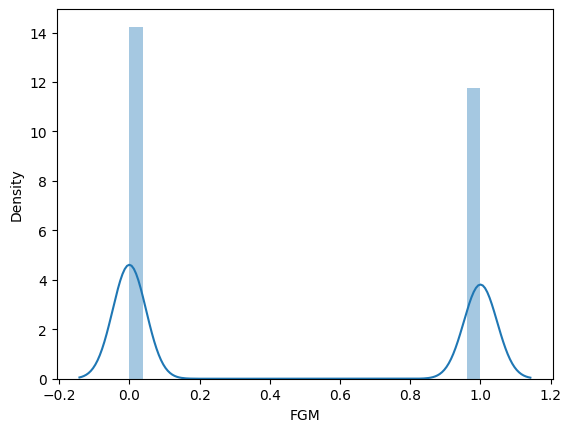

In [ ]:
sns.distplot(y)

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X_DT = selected_features.drop('FGM', axis = 1)
y_DT = selected_features['FGM']
X_DT_train, X_DT_val, y_DT_train, y_DT_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
modelDT = DecisionTreeClassifier(random_state=0)
modelDT.fit(X_DT_train, y_DT_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
y_DT_pred = modelDT.predict(X_DT_val)

In [ ]:
accuracyDT = accuracy_score(y_DT_val, y_DT_pred)
print("Accuracy: {:.2f}%".format(accuracyDT * 100))

Accuracy: 53.90%


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_LR = selected_features.drop('FGM', axis = 1)
y_LR = selected_features['FGM']
X_LR_train, X_LR_val, y_LR_train, y_LR_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
modelLR = LogisticRegression(max_iter=1000)
modelLR.fit(X_LR_train, y_LR_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_LR_pred = modelLR.predict(X_LR_val)

In [ ]:
accuracyLR = accuracy_score(y_LR_val, y_LR_pred)
print("Accuracy: {:.2f}%".format(accuracyLR * 100))

Accuracy: 61.12%


#### K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_KNN = selected_features.drop('FGM', axis = 1)
y_KNN = selected_features['FGM']
X_KNN_train, X_KNN_val, y_KNN_train, y_KNN_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
modelKNN = KNeighborsClassifier()
modelKNN.fit(X_KNN_train, y_KNN_train)

KNeighborsClassifier()

In [ ]:
y_KNN_pred = modelKNN.predict(X_KNN_val)

In [ ]:
accuracyKNN = accuracy_score(y_KNN_val, y_KNN_pred)
print("Accuracy: {:.2f}%".format(accuracyKNN * 100))

Accuracy: 55.75%


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
X_NB = selected_features.drop('FGM', axis = 1)
y_NB = selected_features['FGM']
X_NB_train, X_NB_val, y_NB_train, y_NB_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
modelNB = GaussianNB()
modelNB.fit(X_NB_train, y_NB_train)

GaussianNB()

In [ ]:
y_NB_pred = modelNB.predict(X_NB_val)

In [ ]:
accuracyNB = accuracy_score(y_NB_val, y_NB_pred)
print("Accuracy: {:.2f}%".format(accuracyNB * 100))

Accuracy: 59.47%


### SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
X_SGD = selected_features.drop('FGM', axis = 1)
y_SGD = selected_features['FGM']
X_SGD_train, X_SGD_val, y_SGD_train, y_SGD_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
modelSGD = SGDClassifier()
modelSGD.fit(X_SGD_train, y_SGD_train)

SGDClassifier()

In [ ]:
y_SGD_pred = modelSGD.predict(X_SGD_val)

In [ ]:
accuracySGD = accuracy_score(y_SGD_val, y_SGD_pred)
print("Accuracy: {:.2f}%".format(accuracySGD * 100))

Accuracy: 55.01%


### Finding feature importance with best classifier

In [ ]:
accuracies = pd.DataFrame({'Approach': ['Decision Tree', 'Logistic Regression', 'K Nearest Neighbors', 'Naive Bayes' ,'SGD'], 'Accuracy': [accuracyDT*100, accuracyLR*100, accuracyKNN*100, accuracyNB*100, accuracySGD*100]})

In [ ]:
accuracies.sort_values(by = 'Accuracy', ascending = False)

,Approach,Accuracy
1,Logistic Regression,61.118503
3,Naive Bayes,59.474796
2,K Nearest Neighbors,55.745147
4,SGD,55.005479
0,Decision Tree,53.897934


In [ ]:
importance = modelLR.coef_[0]

In [ ]:
impt = pd.DataFrame({"Features": X.columns, "Feature_Importance": importance})
impt = impt.sort_values(by = 'Feature_Importance', ascending = False)
print(impt)

                      Features  Feature_Importance
5               CLOSE_DEF_DIST            0.104675
2                     DRIBBLES            0.021943
1                   SHOT_CLOCK            0.018134
0                       PERIOD            0.008611
7       SECONDS_LEFT_IN_PERIOD            0.000053
6  CLOSEST_DEFENDER_EFFICIENCY           -0.002894
3                   TOUCH_TIME           -0.052118
4                    SHOT_DIST           -0.060243


In [ ]:
periodImpt = impt[impt.Features == 'PERIOD'].Feature_Importance
shotClkImpt = impt[impt.Features == 'SHOT_CLOCK'].Feature_Importance
dribblesImpt = impt[impt.Features == 'DRIBBLES'].Feature_Importance
ttImpt = impt[impt.Features == 'TOUCH_TIME'].Feature_Importance
shotDistImpt = impt[impt.Features == 'SHOT_DIST'].Feature_Importance
closeDefDistImpt = impt[impt.Features == 'CLOSE_DEF_DIST'].Feature_Importance
closeDefEffImpt = impt[impt.Features == 'CLOSEST_DEFENDER_EFFICIENCY'].Feature_Importance
secLeftImpt = impt[impt.Features == 'SECONDS_LEFT_IN_PERIOD'].Feature_Importance


In [ ]:
df.describe()

,GAME_ID,FINAL_MARGIN,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,player_id,SECONDS_LEFT_IN_PERIOD,ABS_FINAL_MARGIN,CLOSEST_DEFENDER_EFFICIENCY
count,1.277570e+05,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.000000,127757.00000,127757.000000,127757.000000,127757.000000
mean,2.140045e+07,0.209789,2.469595,12.450301,2.02828,2.778727,13.576808,2.264964,159043.963399,4.124012,0.452468,157229.09032,351.409011,10.720477,0.547532
std,2.578955e+02,13.235094,1.139929,5.629991,3.48057,2.987196,8.887801,0.441316,78788.073182,2.756188,0.497738,79369.28322,207.602250,7.764161,0.038680
min,2.140000e+07,-53.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,708.00000,0.000000,1.000000,0.000000
25%,2.140023e+07,-8.000000,1.000000,8.400000,0.00000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,101162.00000,172.000000,5.000000,0.524064
50%,2.140045e+07,1.000000,2.000000,12.450301,1.00000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,201939.00000,352.000000,9.000000,0.547059
75%,2.140067e+07,9.000000,3.000000,16.400000,2.00000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,202704.00000,531.000000,15.000000,0.569472
max,2.140091e+07,53.000000,7.000000,24.000000,32.00000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,204060.00000,720.000000,53.000000,1.000000


In [ ]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255


In [ ]:
for i in players_data['player_id']:
    temp = players_data[players_data['player_id'] == i]
    #Period
    if temp['PERIOD'].iloc[0] > df['PERIOD'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = 0
    else:
      reward = abs((df['PERIOD'].mean()-temp['PERIOD'])/(df['PERIOD'].max() - df['PERIOD'].mean()))*periodImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = reward
    
    #Shot Clock    
    if temp['SHOT_CLOCK'].iloc[0] > df['SHOT_CLOCK'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['SHOT_CLOCK']-df['SHOT_CLOCK'].mean())/(df['SHOT_CLOCK'].max() - df['SHOT_CLOCK'].mean()))*shotClkImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Dribbles    
    if temp['DRIBBLES'].iloc[0] > df['DRIBBLES'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['DRIBBLES']-df['DRIBBLES'].mean())/(df['DRIBBLES'].max() - df['DRIBBLES'].mean()))*dribblesImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    
    #Touch time    
    if temp['TOUCH_TIME'].iloc[0] > df['TOUCH_TIME'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['TOUCH_TIME']-df['TOUCH_TIME'].mean())/(df['TOUCH_TIME'].max() - df['TOUCH_TIME'].mean()))*ttImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Shot Distance
    if temp['shot_distance'].iloc[0] > df['SHOT_DIST'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['shot_distance']-df['SHOT_DIST'].mean())/(df['SHOT_DIST'].max() - df['SHOT_DIST'].mean()))*shotDistImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Distance
    if temp['CLOSE_DEF_DIST'].iloc[0] > df['CLOSE_DEF_DIST'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['CLOSE_DEF_DIST']-df['CLOSE_DEF_DIST'].mean())/(df['CLOSE_DEF_DIST'].max() - df['CLOSE_DEF_DIST'].mean()))*closeDefDistImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Closest Defender Efficiency
    if temp['CLOSEST_DEFENDER_EFFICIENCY'].iloc[0] > df['CLOSEST_DEFENDER_EFFICIENCY'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['CLOSEST_DEFENDER_EFFICIENCY']-df['CLOSEST_DEFENDER_EFFICIENCY'].mean())/(df['CLOSEST_DEFENDER_EFFICIENCY'].max() - df['CLOSEST_DEFENDER_EFFICIENCY'].mean()))*closeDefEffImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    
    #Seconds left in period
    if temp['SECONDS_LEFT_IN_PERIOD'].iloc[0] > df['SECONDS_LEFT_IN_PERIOD'].mean():
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum']
    else:
      reward = abs((temp['SECONDS_LEFT_IN_PERIOD']-df['SECONDS_LEFT_IN_PERIOD'].mean())/(df['SECONDS_LEFT_IN_PERIOD'].max() - df['SECONDS_LEFT_IN_PERIOD'].mean()))*secLeftImpt.iloc[0]
      players_data.loc[players_data['player_id'] == i, 'Weighted_Sum'] = temp['Weighted_Sum'].iloc[0] + reward
    

In [ ]:
players_data

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY,Weighted_Sum
0,0,brian roberts,203148,15.055635,356.928444,0.551191,11.879179,3.662791,4.977996,2.826476,5.422182,559,232,0.415027,0.000897
1,372,bismack biyombo,202687,10.062500,376.730769,0.540020,12.943281,4.152885,2.068269,2.288462,1.355769,104,55,0.528846,0.000344
2,486,al jefferson,2744,12.893411,339.279070,0.543273,13.323462,4.972093,1.401163,2.465116,0.515504,258,111,0.430233,0.000010
3,1286,cody zeller,203469,11.989201,423.242637,0.541412,11.766145,4.889201,1.814867,2.527349,0.538569,713,386,0.541374,0.001074
4,1641,gary neal,202390,9.340881,353.192453,0.542361,10.596858,3.036855,2.658239,2.440252,0.700629,795,380,0.477987,0.002966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,125727,deron williams,101114,18.522193,389.826203,0.553939,12.514318,4.870187,2.124465,2.594920,1.179144,748,336,0.449198,0.000000
277,126242,joe johnson,2207,15.371214,368.956344,0.550207,12.925592,4.066166,2.363847,2.330150,1.499318,733,304,0.414734,0.000265
278,127009,jerome jordan,202366,14.776011,336.862534,0.555221,12.771985,4.146631,4.217251,2.649596,3.967655,371,157,0.423181,0.000002
279,127097,bojan bogdanovic,202711,8.205997,326.401799,0.542076,11.715611,2.955172,2.361469,2.410795,0.848576,667,327,0.490255,0.001269


In [ ]:
players_data['SHOOTER_RANK'] = players_data[['ATTEMPTED_SHOTS', 'SUCCESSFUL_SHOTS', 'SHOOTING_ACCURACY', 'Weighted_Sum']].apply(tuple,axis=1).rank(method='dense',ascending=False).astype(int)

In [ ]:
players_data.sort_values(by = 'SHOOTER_RANK', ascending = False)

,index,player_name,player_id,shot_distance,SECONDS_LEFT_IN_PERIOD,CLOSEST_DEFENDER_EFFICIENCY,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,PERIOD,DRIBBLES,ATTEMPTED_SHOTS,SUCCESSFUL_SHOTS,SHOOTING_ACCURACY,Weighted_Sum,SHOOTER_RANK
98,45605,shawn marion,1890,2.670213,359.212766,0.539821,13.905326,2.691489,1.076596,2.787234,0.170213,47,29,0.617021,0.000000,281
122,56084,kelly olynyk,203482,4.786364,269.795455,0.545292,14.612527,2.593182,1.189773,2.931818,0.340909,88,48,0.545455,0.000012,280
131,60009,aron baynes,203382,3.668478,328.119565,0.532241,13.473386,2.606522,1.401087,2.163043,0.423913,92,49,0.532609,0.000586,279
6,2663,kemba walker,202689,19.117204,326.204301,0.541609,12.752173,5.813978,1.306452,2.408602,0.376344,93,39,0.419355,0.000120,278
195,89483,kyle singler,202713,23.515957,380.234043,0.548816,12.337234,6.253191,1.129787,2.542553,0.329787,94,29,0.308511,0.000178,277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,79310,vince carter,1713,14.011054,340.079836,0.547217,11.873960,4.186899,5.728762,2.403275,4.670420,977,477,0.488229,0.001033,5
57,25868,nene hilario,2403,16.338742,321.127789,0.552258,13.267514,4.149087,5.114807,2.692698,4.953347,986,426,0.432049,0.000004,4
167,77125,khris middleton,203114,13.581687,321.336529,0.542629,11.419091,4.071716,2.488878,2.366251,1.276127,1043,471,0.451582,0.001820,3
198,90596,trevor ariza,2772,14.458611,307.176974,0.550028,12.523991,4.300285,3.960228,2.528069,3.255947,1051,472,0.449096,0.000006,2


https://www.basketball-reference.com/leagues/NBA_2015_shooting.html

## Clustering (OLD)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


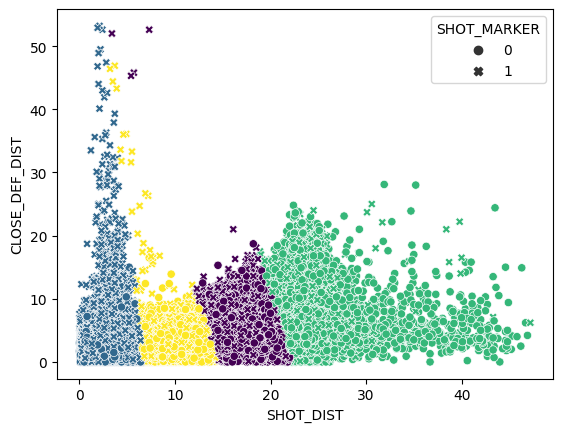

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['SD_CDD_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['SD_CDD_LABELS'] == label]['FGM'])) / float(len(df[df['SD_CDD_LABELS'] == label]['FGM'])))

0 0.40804821150855364
1 0.587699211250665
2 0.35459987397605547
3 0.4053388685074339


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


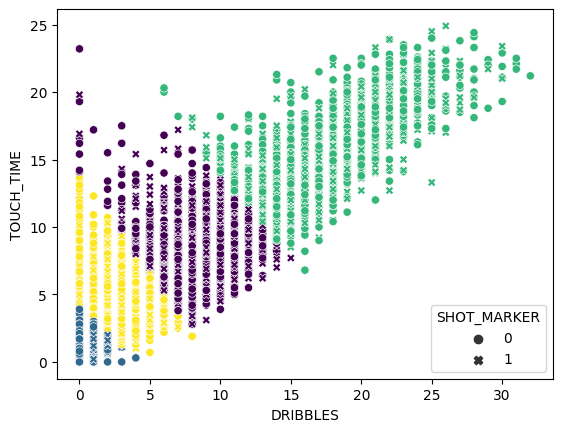

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['DRIBBLES', 'TOUCH_TIME']])

sns.scatterplot(x=df['DRIBBLES'], y=df['TOUCH_TIME'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['D_TT_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['D_TT_LABELS'] == label]['FGM'])) / float(len(df[df['D_TT_LABELS'] == label]['FGM'])))

0 0.4213468425189973
1 0.4691078907379267
2 0.40577507598784196
3 0.42637568199532344


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


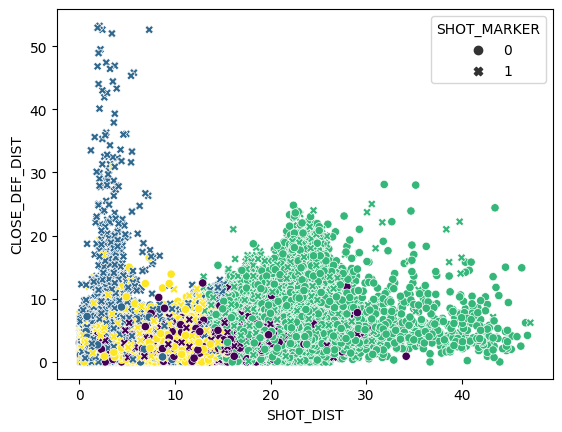

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['SHOT_DIST', 'CLOSE_DEF_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'PTS_TYPE', 'CLOSEST_DEFENDER_EFFICIENCY']])

sns.scatterplot(x=df['SHOT_DIST'], y=df['CLOSE_DEF_DIST'], c=kmeans.labels_, style=df['SHOT_MARKER'])
plt.show()

In [ ]:
df['FULL_CONDITIONS_LABELS'] = kmeans.labels_
for label in range(0, 4):
  print(label, float(sum(df[df['FULL_CONDITIONS_LABELS'] == label]['FGM'])) / float(len(df[df['FULL_CONDITIONS_LABELS'] == label]['FGM'])))

0 0.4120891490319676
1 0.6004472166647052
2 0.3737641334649282
3 0.48424036599399367


In [ ]:
df[['SHOT_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('SHOT_DIST', ascending=False).head()

,SHOT_DIST,FULL_CONDITIONS_LABELS
113017,47.2,2
106851,46.9,2
94461,46.7,2
19112,46.3,2
126697,46.2,2


In [ ]:
df[['CLOSE_DEF_DIST', 'FULL_CONDITIONS_LABELS']].sort_values('CLOSE_DEF_DIST', ascending=False).head()

,CLOSE_DEF_DIST,FULL_CONDITIONS_LABELS
46520,53.2,1
82616,52.9,1
4877,52.6,1
89106,52.6,1
41898,52.0,1
